# YanuX Cruncher Metrics Notebook #

## Imports ##

In [1]:
%matplotlib inline

#Python Standard Library
import sys
import math
import random
import collections
#Pandas
import pandas as pd
#NumPy
import numpy as np                    
#SciPy
import scipy as sp
#Matplotlib
import matplotlib.pyplot as plt       
#scikit-learn
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
import sklearn.metrics
#YanuX Cruncher
from yanux.cruncher.model.loader import JsonLoader
from yanux.cruncher.model.wifi import WifiLogs
import yanux.cruncher.ml.utilities as mlutils

## Load Data ##

In [2]:
json_loader = JsonLoader("data")
wifi_logs = WifiLogs(json_loader.json_data)

Load the data as individual Wi-Fi Results, i.e., each line represents a single Access Point (AP) signal strength measurement.

In [3]:
wifi_results_columns=["filename", "x", "y", "floor", "sample_id", "mac_address", "timestamp", "signal_strength"]
wifi_results = pd.DataFrame(wifi_logs.wifi_results(), columns=wifi_results_columns)

Load the data as aggregated Wi-Fi Sample, i.e., each line represents a point in time at which a scan for Wi-Fi networks was performed. Each column beyond *filename*, *x*, *y*, *floor*, *sample_id* and *timestamp* represents a different AP and the values at each of those columns are the AP's signal strength when each of the samples was taken.

Whenever a sample didn't capture an AP's signal, either because it was completely out of range, or because the signal was so weak that it was just ignored by the hardware and software stack, the value was considered to an arbitrarly low value.

In [4]:
mac_addresses = wifi_results.mac_address.unique()
wifi_samples_columns = ["filename", "x", "y", "floor", "sample_id", "timestamp"]
wifi_samples_columns.extend(mac_addresses)

wifi_samples = pd.DataFrame(wifi_logs.wifi_samples(), columns=wifi_samples_columns)

wifi_samples = wifi_samples.sort_values(["filename", "x", "y", "floor", "sample_id", "timestamp"]).reset_index(drop=True)

wifi_samples = wifi_samples.fillna(-100)

rescaled_data = mlutils.normalize(wifi_samples[mac_addresses], mode="rescale")

standardized_data = mlutils.normalize(wifi_samples[mac_addresses], mode="standardize")

normalized_data = pd.merge(rescaled_data, standardized_data, left_index=True, right_index=True, suffixes=['_rescale', '_standardize'])

wifi_samples = wifi_samples.join(normalized_data)

wifi_samples["error"] = 0.0

Split the samples into training and test data

In [5]:
# 60% of the data will be used for training. The rest will be used for testing.
train_data_ratio = 0.60 
train_ids = []
test_ids = []
for key, indices in wifi_samples.groupby(["x","y","floor"]).indices.items():
    slice_index = int(len(indices) * train_data_ratio)
    #random.shuffle(indices)
    train_ids.extend(indices[:slice_index])
    test_ids.extend(indices[slice_index:])
    
wifi_samples_train = wifi_samples.ix[train_ids].reset_index(drop=True)
wifi_samples_test = wifi_samples.ix[test_ids].reset_index(drop=True)

### Save everything to CSV ###

In [6]:
wifi_results.to_csv("wifi_results.csv")
wifi_samples.to_csv("wifi_samples.csv")
wifi_samples_train.to_csv("wifi_samples_train.csv")
wifi_samples_test.to_csv("wifi_samples_test.csv")

## Plots ##

### The coordinates of the points where data was captured ###

(-1.875, 39.375, -0.025000000000000022, 11.525)

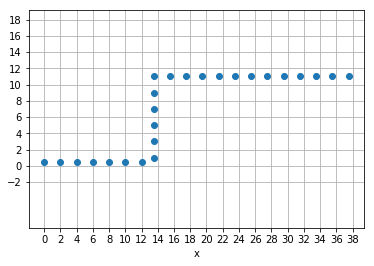

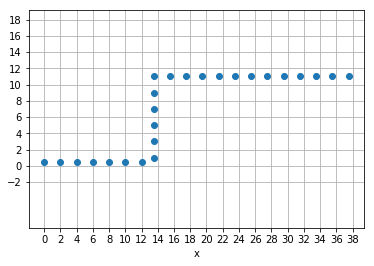

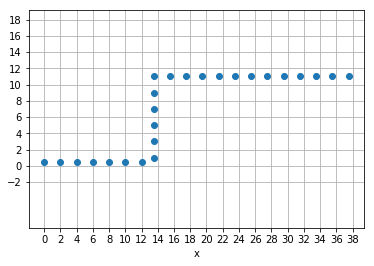

In [7]:
coords = wifi_samples_train[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_plot_size = (min(coords["x"].min(),coords["y"].min())-2, max(coords["x"].max(),coords["y"].max())+2)
coords.plot(x="x",y="y", style="o", grid=True, legend=False,
            xlim=coords_plot_size, ylim=coords_plot_size,
            xticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2),
            yticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2)).axis('equal')

coords_train = wifi_samples_test[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_train.plot(x="x",y="y", style="o", grid=True, legend=False,
                  xlim=coords_plot_size, ylim=coords_plot_size,
                  xticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2),
                  yticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2)).axis('equal')

coords_test = wifi_samples[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_test.plot(x="x",y="y", style="o", grid=True, legend=False,
                 xlim=coords_plot_size, ylim=coords_plot_size,
                 xticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2),
                 yticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2)).axis('equal')

### Signal Strength Distribution ###

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000175AE3289B0>]], dtype=object)

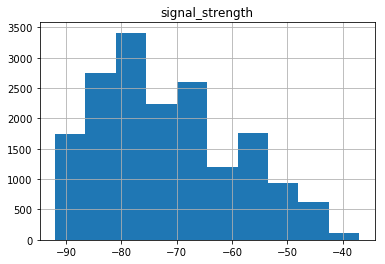

In [8]:
wifi_results.hist(column="signal_strength")

### How often has each Access Point been detected? ###

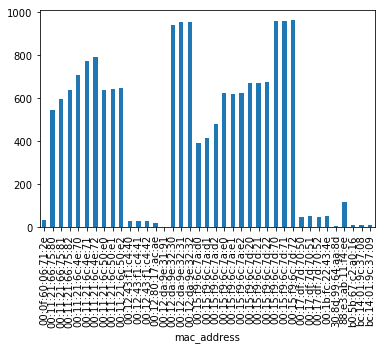

In [9]:
mac_address_group = wifi_results.groupby("mac_address")
mac_address_group.size().plot(kind="bar")
# mac_address_group.size()

### How many times were Wi-Fi results collected at each location? ###

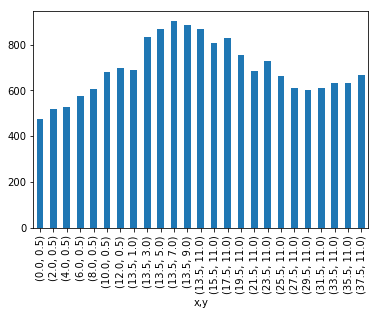

In [10]:
coord_group = wifi_results.groupby(["x", "y"])
coord_group.size().plot(kind="bar")
# coord_group.size()

## Positioning ##

Generalizing regression experiments

In [11]:
def regression_experiment(regressor, training_data, train_cols, target_cols, test_data, predicted_cols):
    regressor.fit(training_data[train_cols], training_data[target_cols])
    predictions = pd.DataFrame(regressor.predict(test_data[train_cols]), columns=predicted_cols)
    results = pd.concat([test_data[target_cols], predictions], axis=1)
    
    results["euclidean_distance_error"] = 0
    for col in target_cols:
        results["euclidean_distance_error"] += (results[col] - results[col+"_predicted"])**2
    results["euclidean_distance_error"] = results["euclidean_distance_error"].apply(np.sqrt)
    
    return results

Running multiple regressions experiments, with varying parameters and implementations, while collecting the results for further analysis.

In [12]:
regressors = collections.OrderedDict()
for i in range(1, 6):
    regressors["knn"+str(i)] = KNeighborsRegressor(n_neighbors=i,
                                                   algorithm="brute",
                                                   weights="distance")    
results = collections.OrderedDict()
for key, regressor in regressors.items():
    results[key] = regression_experiment(regressor, wifi_samples_train,
                                         mac_addresses, ["x","y"],
                                         wifi_samples_test, ["x_predicted","y_predicted"])
# for key, regressor in regressors.items():
#     results[key+"_rescale"] = regression_experiment(regressor, wifi_samples_train,
#                                                     [col+"_rescale" for col in mac_addresses], ["x","y"],
#                                                     wifi_samples_test, ["x_predicted","y_predicted"])
# for key, regressor in regressors.items():
#     results[key+"_standardize"] = regression_experiment(regressor, wifi_samples_train,
#                                                         [col+"_standardize" for col in mac_addresses], ["x","y"], 
#                                                         wifi_samples_test, ["x_predicted","y_predicted"])

Given the collected results compute some performance metrics to compare the available options

In [13]:
metrics = collections.OrderedDict()
for key, result in results.items():
    metrics[key] = collections.OrderedDict()
    
    metrics[key]["mean_absolute_error"] = sklearn.metrics.mean_absolute_error(wifi_samples_test["error"], result["euclidean_distance_error"])
    metrics[key]["std_dev_distance_error"] = results[key]["euclidean_distance_error"].std()

    metrics[key]["mean_squared_error"] = sklearn.metrics.mean_squared_error(wifi_samples_test["error"], result["euclidean_distance_error"])
    metrics[key]["median_absolute_error"] = sklearn.metrics.median_absolute_error(wifi_samples_test["error"], result["euclidean_distance_error"])
    
    metrics[key]["percentile_90"] = results[key]["euclidean_distance_error"].quantile(q=0.9)
    metrics[key]["percentile_95"] = results[key]["euclidean_distance_error"].quantile(q=0.95)

metrics_table = pd.DataFrame.from_dict(metrics)
metrics_table.to_csv("metrics.csv")

# metrics_table.T.plot(figsize=(10, 10))
metrics_table

,knn1,knn2,knn3,knn4,knn5
mean_absolute_error,0.755000,8.798090e-01,1.001513,1.105193,1.191423
mean_squared_error,2.790000,2.442316e+00,2.566483,2.650589,2.857165
median_absolute_error,0.000000,3.972055e-15,0.591407,0.841600,0.896331
percentile_90,2.000000,2.000741e+00,2.600670,2.668694,2.855236
percentile_95,4.000000,3.818288e+00,3.408204,3.057010,3.517846
std_dev_distance_error,1.491824,1.293226e+00,1.251948,1.196962,1.200533
